## Lab 2-1

In [1]:
# Importing useful packages

import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
import h5py
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

%matplotlib inline

np.random.seed(1) 

## Dataset

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [2]:
# Loading the dataset

X, Y = load_planar_dataset()

Visualize the dataset using matplotlib. The data looks like a "flower" with some red (label y=0) and some blue (y=1) points. Your goal is to build a model to fit this data. 

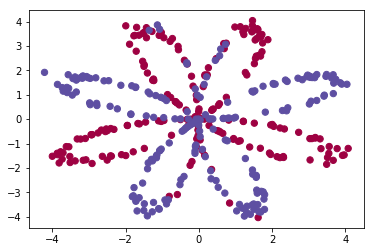

In [3]:
# Visualizing the data

plt.scatter(X[0, :], X[1, :], c=Y.ravel(), s=40, cmap=plt.cm.Spectral);

You have:
    - a numpy-array (matrix) X that contains your features (x1, x2)
    - a numpy-array (vector) Y that contains your labels (red:0, blue:1).

Lets first get a better sense of what our data is like. 

**Exercise**: How many training examples do you have? In addition, what is the `shape` of the variables `X` and `Y`? 

**Hint**: How do you get the shape of a numpy array? [(help)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html)

In [4]:
# Shape of the dataset

shape_X = X.shape
shape_Y = Y.shape
m = shape_X[1]

print ('The shape of X is: ' + str(shape_X))
print ('The shape of Y is: ' + str(shape_Y))
print ('I have m = %d training examples!' % (m))

The shape of X is: (2, 400)
The shape of Y is: (1, 400)
I have m = 400 training examples!


**Expected Output**:
       
<table style="width:20%">
  
  <tr>
    <td>**shape of X**</td>
    <td> (2, 400) </td> 
  </tr>
  
  <tr>
    <td>**shape of Y**</td>
    <td>(1, 400) </td> 
  </tr>
  
  <tr>
    <td>**m**</td>
    <td> 400 </td> 
  </tr>
  
</table>

## Simple Logistic Regression

Before building a full neural network, lets first see how logistic regression performs on this problem. You can use sklearn's built-in functions to do that. We can train a logisitc regression model by performing the following steps:
- Use the following sklearn function to define the logistic regression model: *sklearn.linear_model.LogisticRegressionCV()*
- Use X and Y to fit the model using the member function *fit(X,Y)* (remember to use transpose)

In [5]:
# Training the logistic Regression Classifier

clf = sklearn.linear_model.LogisticRegressionCV(cv = 5, random_state= 0, multi_class='multinomial')

# Fitting the model using fit(X,Y)

clf.fit(X.T,np.ravel(Y))

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=0, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

You can now plot the decision boundary of these models. Run the code below.

Accuracy of logistic regression: 47 % (percentage of correctly labelled datapoints)


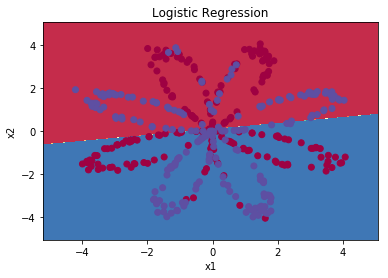

In [6]:
# Plotting the Decision Boundary for logistic Regression

plot_decision_boundary(lambda x: clf.predict(x), X, Y.ravel())
plt.title("Logistic Regression")

# Printing the Accuracy

LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

**Expected Output**:

<table style="width:20%">
  <tr>
    <td>**Accuracy**</td>
    <td> 47% </td> 
  </tr>
  
</table>


**Interpretation**: The dataset is not linearly separable, so logistic regression doesn't perform well. Hopefully a neural network will do better. Let's try this now! 

Reference:
- http://scs.ryerson.ca/~aharley/neural-networks/
- http://cs231n.github.io/neural-networks-case-study/

## Lab 2-2

## Neural Network model

You are going to train a Neural Network with a single hidden layer.

**Here is our model**:
<img src="images/classification_kiank.png" style="width:600px;height:300px;">

**Mathematically**:

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1] (i)}\tag{1}$$ 
$$a^{[1] (i)} = \tanh(z^{[1] (i)})\tag{2}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2] (i)}\tag{3}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{4}$$
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}\tag{5}$$

Given the predictions on all the examples, you can also compute the cost $J$ as follows: 
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small \tag{6}$$

**Reminder**: The general methodology to build a Neural Network is to:
    1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
    2. Initialize the model's parameters
    3. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)

You often build helper functions to compute steps 1-3 and then merge them into one function we call `nn_model()`. Once you've built `nn_model()` and learnt the right parameters, you can make predictions on new data.

### Defining the neural network structure ####

**Exercise**: Define three variables:
    - n_x: the size of the input layer
    - n_h: the size of the hidden layer (set this to 4) 
    - n_y: the size of the output layer

**Hint**: Use shapes of X and Y to find n_x and n_y. Also, hard code the hidden layer size to be 4.

In [7]:
# Defining the Neural Network Structure

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    
    n_x = X.shape[0] 
    n_h = 4
    n_y = Y.shape[0] 
    
    return (n_x, n_h, n_y)

In [8]:
X_assess, Y_assess = layer_sizes_test_case()
(n_x, n_h, n_y) = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


**Expected Output** (these are not the sizes you will use for your network, they are just used to assess the function you've just coded).

<table style="width:20%">
  <tr>
    <td>**n_x**</td>
    <td> 5 </td> 
  </tr>
  
  <tr>
    <td>**n_h**</td>
    <td> 4 </td> 
  </tr>
  
  <tr>
    <td>**n_y**</td>
    <td> 2 </td> 
  </tr>
  
</table>

### Initialize the model's parameters ####

**Exercise**: Implement the function `initialize_parameters()`.

**Instructions**:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.
- You will initialize the weights matrices with random values. 
    - Use: `np.random.randn(a,b) * 0.01` to randomly initialize a matrix of shape (a,b).
- You will initialize the bias vectors as zeros. 
    - Use: `np.zeros((a,b))` to initialize a matrix of shape (a,b) with zeros.

In [9]:
# Initializing the Model's Parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) 
    
    
    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros(shape = (n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros(shape = (n_y, 1))
    
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [10]:
n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.01057952 -0.00909008  0.00551454  0.02292208]]
b2 = [[0.]]


**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00416758 -0.00056267]
 [-0.02136196  0.01640271]
 [-0.01793436 -0.00841747]
 [ 0.00502881 -0.01245288]] </td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]] </td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01057952 -0.00909008  0.00551454  0.02292208]]</td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.]] </td> 
  </tr>
  
</table>



### The Loop ####

**Question**: Implement `forward_propagation()`.

**Instructions**:
- Look above at the mathematical representation of your classifier.
- You can use the function `sigmoid()`. It is built-in (imported) in the notebook.
- You can use the function `np.tanh()`. It is part of the numpy library.
- The steps you have to implement are:
    1. Retrieve each parameter from the dictionary "parameters" (which is the output of `initialize_parameters()`) by using `parameters[".."]`.
    2. Implement Forward Propagation. Compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all your predictions on all the examples in the training set).
- Values needed in the backpropagation are stored in "`cache`". The `cache` will be given as an input to the backpropagation function.

In [11]:
# Implementing the Forward Propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    
    # Retrieve each parameter from the dictionary "parameters"
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    
    Z1 = np.matmul(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.matmul(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [12]:
X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

-0.0004997557777419902 -0.000496963353231779 0.00043818745095914653 0.500109546852431


**Expected Output**:
<table style="width:55%">
  <tr>
    <td> -0.000499755777742 -0.000496963353232 0.000438187450959 0.500109546852 </td> 
  </tr>
</table>

Now that you have computed $A^{[2]}$ (in the Python variable "`A2`"), which contains $a^{[2](i)}$ for every example, you can compute the cost function as follows:

$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small\tag{13}$$

**Exercise**: Implement `compute_cost()` to compute the value of the cost $J$.

**Instructions**:
- There are many ways to implement the cross-entropy loss. To help you, we give you how we would have implemented
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})$:
```python
logprobs = np.multiply(np.log(A2),Y)
cost = - np.sum(logprobs)                # no need to use a for loop!
```

(you can use either `np.multiply()` and then `np.sum()` or directly `np.dot()`).
-  Use `np.squeeze()` to make sure cost dimension is a value rather than a array (turns [[17]] into 17 ). 


In [13]:
# Computing the Cost 

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] 
    
    # Compute the cross-entropy cost
    
    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1 - A2), (1 - Y))
    cost = -(1. / m) * np.sum(logprobs)
    cost = np.squeeze(cost)    
    
    # Cost dimension should be a floating point value.
    
    assert(isinstance(cost, float))
    
    return cost

In [14]:
A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))

cost = 0.6929198937761265


**Expected Output**:
<table style="width:20%">
  <tr>
    <td>**cost**</td>
    <td> 0.692919893776 </td> 
  </tr>
  
</table>

## Lab 2-3

## Backward Propagation

**Question**: Implement the function `backward_propagation()`.

**Instructions**:
Backpropagation is usually the hardest (most mathematical) part in deep learning. To help you, here again is the slide from the lecture on backpropagation. You'll want to use the six equations on the right of this slide, since you are building a vectorized implementation.  

<img src="images/grad_summary.png" style="width:600px;height:300px;">

<!--
$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$

$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $

$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$

$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $

$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $

$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$

- Note that $*$ denotes elementwise multiplication.
- The notation you will use is common in deep learning coding:
    - dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$
    - db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$
    - dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$
    - db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$
    
!-->

- Tips:
    - To compute dZ1 you'll need to compute $g^{[1]'}(Z^{[1]})$. Since $g^{[1]}(.)$ is the tanh activation function, if $a = g^{[1]}(z)$ then $g^{[1]'}(z) = 1-a^2$. So you can compute 
    $g^{[1]'}(Z^{[1]})$ using `(1 - np.power(A1, 2))`.

In [15]:
# Implementing the Backward Propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = Y.shape[1]
    
    # Retrieving W1 and W2 from the dictionary 'parameters'
    
    W1 = parameters["W1"]
    W2 = parameters["W2"]
            
    # Retrieving also A1 and A2 from dictionary 'cache'
    
    A1 = cache["A1"]
    A2 = cache["A2"]
    
    
    # Backward Propagation- Calculating dW1, db1, dW2, db2. 
    
    dZ2= A2 - Y
    dW2 = (1. / m) * np.matmul(dZ2, A1.T)
    db2 = (1. / m) * np.sum(dZ2, axis=1, keepdims=True)
    dZ1 = np.matmul(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = (1. / m) * np.matmul(dZ1, X.T)
    db1 = (1. / m) * np.sum(dZ1, axis=1, keepdims=True)
    
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [16]:
parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


**Expected output**:



<table style="width:80%">
  <tr>
    <td>**dW1**</td>
    <td> [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]] </td> 
  </tr>
  
  <tr>
    <td>**db1**</td>
    <td>  [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]] </td> 
  </tr>
  
  <tr>
    <td>**dW2**</td>
    <td> [[ 0.00363613  0.03153604  0.01162914 -0.01318316]] </td> 
  </tr>
  

  <tr>
    <td>**db2**</td>
    <td> [[ 0.06589489]] </td> 
  </tr>
  
</table>  

**Question**: Implement the update rule. Use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="images/sgd.gif" style="width:400;height:400;"> <img src="images/sgd_bad.gif" style="width:400;height:400;">



In [17]:
# Updating the Parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieving each parameter from the dictionary 'parameters'
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
       
    # Retrieving each gradient from the dictionary 'grads'
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    
    # Updating rule for each parameter
   
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [18]:
parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


**Expected Output**:


<table style="width:80%">
  <tr>
    <td>**W1**</td>
    <td> [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ -1.02420756e-06]
 [  1.27373948e-05]
 [  8.32996807e-07]
 [ -3.20136836e-06]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-0.01041081 -0.04463285  0.01758031  0.04747113]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[ 0.00010457]] </td> 
  </tr>
  
</table>  

## Lab 2-4

## Building the Neural Network model ##

**Question**: Build your neural network model in `nn_model()`.

**Instructions**: The neural network model has to use the support functions we developed in *lab_2_2* and *lab_2_3* in the right order.

In [19]:
# Building the Neural Network Model- nn_model()

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = X.shape[0] 
    n_y = Y.shape[0] 

    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        
        # Forward propagation: Inputs- 'X, parameters', Outputs- 'A2, cache'
        
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function: Inputs- 'A2, Y, parameters', Outputs- 'cost'
        
        cost = compute_cost(A2, Y, parameters)
 
        # Backward Propagation: Inputs- 'parameters, cache, X, Y', Outputs: 'grads'
    
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient Descent Parameter Update: Inputs- 'parameters, grads', Outputs- 'parameters'
    
        parameters = update_parameters(parameters, grads, learning_rate = 1.2)
           
        # Printing the Cost every 1000 iterations
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        
    return parameters

In [20]:
X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

Cost after iteration 0: 0.692584
Cost after iteration 1000: -inf


C:\Users\Dipam\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


Cost after iteration 2000: -inf
Cost after iteration 3000: -inf
Cost after iteration 4000: -inf
Cost after iteration 5000: -inf
Cost after iteration 6000: -inf
Cost after iteration 7000: -inf
Cost after iteration 8000: -inf
Cost after iteration 9000: -inf
W1 = [[-4.18494482  5.33220319]
 [-7.52989354  1.24306197]
 [-4.19295428  5.32631786]
 [ 7.52983748 -1.24309404]]
b1 = [[ 2.32926815]
 [ 3.7945905 ]
 [ 2.33002544]
 [-3.79468791]]
W2 = [[-6033.83672179 -6008.12981272 -6033.10095329  6008.06636901]]
b2 = [[-52.66607704]]


**Expected Output**:

<table style="width:90%">
  <tr>
    <td>**W1**</td>
    <td> [[-4.18494056  5.33220609]
 [-7.52989382  1.24306181]
 [-4.1929459   5.32632331]
 [ 7.52983719 -1.24309422]]</td> 
  </tr>
  
  <tr>
    <td>**b1**</td>
    <td> [[ 2.32926819]
 [ 3.79458998]
 [ 2.33002577]
 [-3.79468846]]</td> 
  </tr>
  
  <tr>
    <td>**W2**</td>
    <td> [[-6033.83672146 -6008.12980822 -6033.10095287  6008.06637269]] </td> 
  </tr>
  

  <tr>
    <td>**b2**</td>
    <td> [[-52.66607724]] </td> 
  </tr>
  
</table>  

### Predictions

**Question**: Use your model to predict by building predict().
Use forward propagation to predict results.

**Reminder**: predictions = $y_{prediction} = \mathbb 1 \text{{activation > 0.5}} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    
As an example, if you would like to set the entries of a matrix X to 0 and 1 based on a threshold you would do: ```X_new = (X > threshold)```


In [21]:
# Predicting the Result using Forward Propagation

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    
    A2, cache = forward_propagation(X, parameters)
    threshold = 0.5
    predictions = (A2 > threshold)
        
    return predictions

In [22]:
parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


**Expected Output**: 


<table style="width:40%">
  <tr>
    <td>**predictions mean**</td>
    <td> 0.666666666667 </td> 
  </tr>
  
</table>

## Lab 2-5

### Training the model

It is time to run the model and see how it performs on a planar dataset. Run the following code to test your model with a single hidden layer of $n_h$ hidden units.
- Use the `nn_model()` to calculate the model parameters on the X,Y data imported in *lab_2_1*.
- Use the `predict()` to calculate the model predections on X and plot the decision boundries.

Cost after iteration 0: 0.693048
Cost after iteration 1000: 0.288083
Cost after iteration 2000: 0.254385
Cost after iteration 3000: 0.233864
Cost after iteration 4000: 0.226792
Cost after iteration 5000: 0.222644
Cost after iteration 6000: 0.219731
Cost after iteration 7000: 0.217504
Cost after iteration 8000: 0.219504
Cost after iteration 9000: 0.218571


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

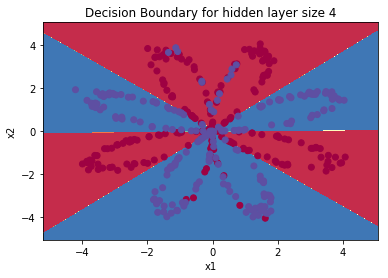

In [23]:
# Building a Model with a n_h-dimensional Hidden Layer

parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost = True)

# Plotting the Decision Boundary

plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))

**Expected Output**:

<table style="width:40%">
  <tr>
    <td>**Cost after iteration 9000**</td>
    <td> 0.218607 </td> 
  </tr>
  
</table>


In [24]:
# Printing the Accuracy

predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy: 90%


**Expected Output**: 

<table style="width:15%">
  <tr>
    <td>**Accuracy**</td>
    <td> 90% </td> 
  </tr>
</table>

Accuracy is really high compared to Logistic Regression. The model has learnt the leaf patterns of the flower! Neural networks are able to learn even highly non-linear decision boundaries, unlike logistic regression. 

Now, let's try out several hidden layer sizes.

### Tuning hidden layer size  ###

In the following code, populate the *hidden_layer_sizes* list with different values such as $[1, 2, 3, 4, 5, 20, 50]$. It may take few minutes. You will observe different behaviors of the model for various hidden layer sizes.

Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 90.0 %
Accuracy for 50 hidden units: 90.75 %


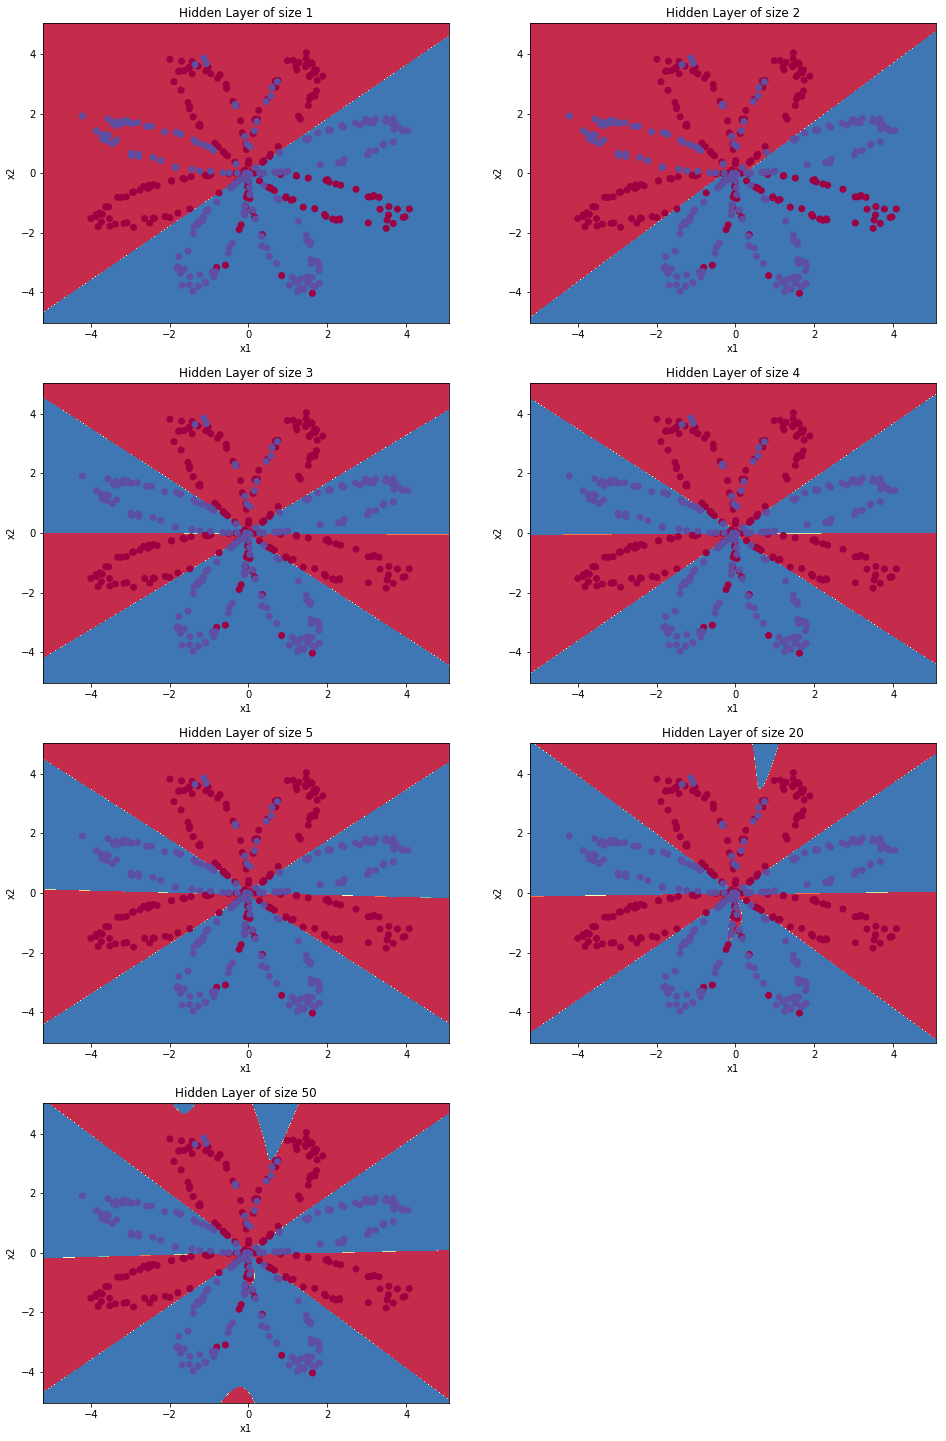

In [25]:
# Tuning the Hidden Layer Size

plt.figure(figsize=(16, 32))

# Populating with Different Layer Size

hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y.ravel())
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 5. Indeed, a value around here seems to  fits the data well without also incurring noticable overfitting.
- You will also learn later about regularization, which lets you use very large models (such as n_h = 50) without much overfitting. 

## Lab 2-6

## Performance on other datasets
Complete this notebook to train and plot the prediction of the NN model on the following datasets.

In [26]:
# Loading the Datasets

noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

In [27]:
# Building the Neural Network Model- nn_model()

def nn_model(X, Y, n_h,learning_rate, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    # Initializing parameters, then retrieving W1, b1, W2, b2: Inputs- 'n_x, n_h, n_y', Outputs- 'W1, b1, W2, b2, parameters'
    
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
   
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        
        # Forward Propagation: Inputs- 'X, parameters', Outputs- 'A2, cache'
        
        A2, cache = forward_propagation(X,parameters)
        
        # Cost function: Inputs- 'A2, Y, parameters', Outputs- 'cost'
        
        cost = compute_cost(A2,Y,parameters)
 
        # Backward Propagation: Inputs- 'parameters, cache, X, Y', Outputs- 'grads'
        
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient Descent Parameter Update: Inputs- 'parameters, grads', Outputs- 'parameters'
        
        parameters = update_parameters(parameters, grads, learning_rate)
           
        # Printing the Cost every 1000 iterations
        
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        
    return parameters

Cost after iteration 0: 0.693155
Cost after iteration 1000: 0.450026
Cost after iteration 2000: 0.425231
Cost after iteration 3000: 0.431253
Cost after iteration 4000: 0.431356
Cost after iteration 5000: 0.431040
Cost after iteration 6000: 0.430653
Cost after iteration 7000: 0.430309
Cost after iteration 8000: 0.430031
Cost after iteration 9000: 0.429812
Accuracy: 76%


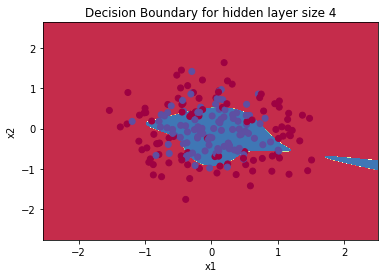

In [28]:
# Computing the Cost & Accuracy for Noisy Circles

noisy_circles_X = np.asarray(datasets['noisy_circles'][0]).T
noisy_circles_Y = np.asarray(datasets['noisy_circles'][1])
noisy_circles_Y = noisy_circles_Y.reshape((1,noisy_circles_Y.shape[0]))

# print(noisy_circles_X.shape)
# print(noisy_circles_Y.shape)

n_h = 4
parameters = nn_model(noisy_circles_X, noisy_circles_Y, n_h,1.2,print_cost=True) #None
plot_decision_boundary(lambda x: predict(parameters, x.T), noisy_circles_X, noisy_circles_Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, noisy_circles_X)
print ('Accuracy: %d' % float((np.dot(noisy_circles_Y,predictions.T) + np.dot(1-noisy_circles_Y,1-predictions.T))/float(noisy_circles_Y.size)*100) + '%')

Cost after iteration 0: 0.693148
Cost after iteration 1000: 0.679965
Cost after iteration 2000: 0.675640
Cost after iteration 3000: 0.672208
Cost after iteration 4000: 0.671055
Cost after iteration 5000: 0.665277
Cost after iteration 6000: 0.660295
Cost after iteration 7000: 0.657609
Cost after iteration 8000: 0.655920
Cost after iteration 9000: 0.654806
Accuracy: 57%


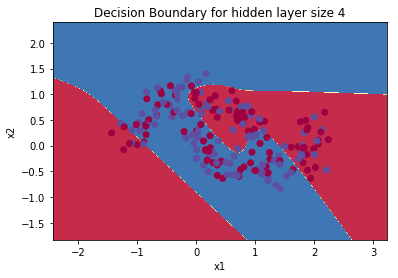

In [29]:
# Computing the Cost & Accuracy for Noisy Moons

noisy_moons_X = np.asarray(datasets['noisy_moons'][0]).T
noisy_moons_Y = np.asarray(datasets['noisy_moons'][1])
noisy_moons_Y = noisy_circles_Y.reshape((1,noisy_moons_Y.shape[0]))

# print(noisy_moons_X.shape)
# print(noisy_moons_Y.shape)

n_h = 4
parameters = nn_model(noisy_moons_X, noisy_moons_Y, n_h,1.2,print_cost=True) #None
plot_decision_boundary(lambda x: predict(parameters, x.T), noisy_moons_X, noisy_moons_Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, noisy_circles_X)
print ('Accuracy: %d' % float((np.dot(noisy_moons_Y,predictions.T) + np.dot(1-noisy_moons_Y,1-predictions.T))/float(noisy_moons_Y.size)*100) + '%')


Cost after iteration 0: 0.693388
Cost after iteration 1000: 0.226557
Cost after iteration 2000: 0.220900
Cost after iteration 3000: 0.217511
Cost after iteration 4000: 0.215223
Cost after iteration 5000: 0.214013
Cost after iteration 6000: 0.213190
Cost after iteration 7000: 0.211840
Cost after iteration 8000: 0.211269
Cost after iteration 9000: 0.210825
Accuracy: 88%


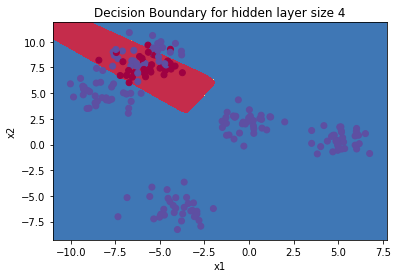

In [30]:
# Computing the Cost & Accuracy for Blobs

blobs_X = np.asarray(datasets["blobs"][0]).T
blobs_Y = np.where(blobs[1]>0,1,0).reshape(1,blobs[1].shape[0])

# print(blobs_X.shape)
# print(blobs_Y.shape)

n_h = 4
parameters = nn_model(blobs_X, blobs_Y, n_h,1.2,print_cost=True) 
plot_decision_boundary(lambda x: predict(parameters, x.T), blobs_X, blobs_Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, blobs_X)
print ('Accuracy: %d' % float((np.dot(blobs_Y,predictions.T) + np.dot(1-blobs_Y,1-predictions.T))/float(blobs_Y.size)*100) + '%')


Cost after iteration 0: 0.693130
Cost after iteration 1000: 0.102746
Cost after iteration 2000: 0.081104
Cost after iteration 3000: 0.073966
Cost after iteration 4000: 0.090230
Cost after iteration 5000: 0.079213
Cost after iteration 6000: 0.093826
Cost after iteration 7000: 0.068783
Cost after iteration 8000: 0.067218
Cost after iteration 9000: 0.067203
Accuracy: 97%


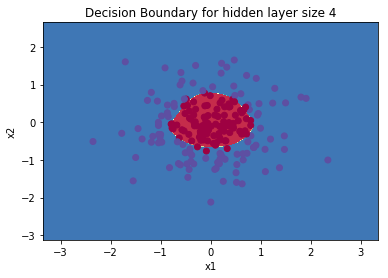

In [31]:
# Computing the Cost & Accuracy for Gaussian Quantiles

gaussian_quantiles_X = np.asarray(datasets['gaussian_quantiles'][0]).T
gaussian_quantiles_Y = np.asarray(datasets['gaussian_quantiles'][1])
gaussian_quantiles_Y = gaussian_quantiles_Y.reshape((1,gaussian_quantiles_Y.shape[0]))

# print(gaussian_quantiles_X.shape)
# print(gaussian_quantiles_Y.shape)

n_h = 4
parameters = nn_model(gaussian_quantiles_X, gaussian_quantiles_Y, n_h,1.2,print_cost=True)
plot_decision_boundary(lambda x: predict(parameters, x.T), gaussian_quantiles_X, gaussian_quantiles_Y.ravel())
plt.title("Decision Boundary for hidden layer size " + str(4))
predictions = predict(parameters, gaussian_quantiles_X)
print ('Accuracy: %d' % float((np.dot(gaussian_quantiles_Y,predictions.T) + np.dot(1-gaussian_quantiles_Y,1-predictions.T))/float(gaussian_quantiles_Y.size)*100) + '%')

In [32]:
# loading Dataset and splitting it into train, dev and test set

def load_dataset(database_path):
    
    dataset_db = h5py.File(database_path, "r")
    
    
    datasets = {}
    for dataset in ["train", "dev", "test"]:
        
        datasets[dataset] = {'X' : np.array(dataset_db[dataset + "_img"][:]), 
                              'Y' : np.array(dataset_db[dataset + "_labels"][:]) 
                            }
    return datasets

In [33]:
# Testing Trained Model on the Car Dataset

datasets = load_dataset('car_dataset.hdf5')

train_set_x_orig = datasets["train"]["X"]
train_set_y_orig = datasets["train"]["Y"]

test_set_x_orig = datasets["test"]["X"] 
test_set_y_orig = datasets["test"]["Y"]

dev_set_x_orig = datasets["dev"]["X"]
dev_set_y_orig = datasets["dev"]["Y"]

train_set_y_orig = train_set_y_orig.reshape((1,train_set_y_orig.shape[0]))
test_set_y_orig = test_set_y_orig.reshape((1,test_set_y_orig.shape[0]))
dev_set_y_orig = dev_set_y_orig.reshape((1,dev_set_y_orig.shape[0]))

In [34]:
# Fixing ill-shaped Vectors (Data)

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
m_dev = dev_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

# Flattening the Data

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
dev_set_x_flatten = dev_set_x_orig.reshape(dev_set_x_orig.shape[0], -1).T

# Standardizing the Data

train_set_x = train_set_x_flatten/255
test_set_x = test_set_x_flatten/255
dev_set_x = dev_set_x_flatten/255

In [35]:
# Computing the Cost & Accuracy for Test Set

n_h = 4
parameters = nn_model(train_set_x, train_set_y_orig, n_h,0.1,print_cost=True) 
predictions = predict(parameters, test_set_x)
print ('Accuracy: %d' % float((np.dot(test_set_y_orig,predictions.T) + np.dot(1-test_set_y_orig,1-predictions.T))/float(test_set_y_orig.size)*100) + '%')


Cost after iteration 0: 0.690994
Cost after iteration 1000: 0.106823
Cost after iteration 2000: 0.057337
Cost after iteration 3000: 0.037687
Cost after iteration 4000: 0.034653
Cost after iteration 5000: 0.028490
Cost after iteration 6000: 0.027127
Cost after iteration 7000: 0.026399
Cost after iteration 8000: 0.025942
Cost after iteration 9000: 0.025628
Accuracy: 87%


In [36]:
# Computing the Cost & Accuracy for Dev Set

n_h = 4
parameters = nn_model(train_set_x, train_set_y_orig, n_h,0.1,print_cost=True)
predictions = predict(parameters, dev_set_x)
print ('Accuracy: %d' % float((np.dot(dev_set_y_orig,predictions.T) + np.dot(1-dev_set_y_orig,1-predictions.T))/float(dev_set_y_orig.size)*100) + '%')

Cost after iteration 0: 0.690994
Cost after iteration 1000: 0.106823
Cost after iteration 2000: 0.057337
Cost after iteration 3000: 0.037687
Cost after iteration 4000: 0.034653
Cost after iteration 5000: 0.028490
Cost after iteration 6000: 0.027127
Cost after iteration 7000: 0.026399
Cost after iteration 8000: 0.025942
Cost after iteration 9000: 0.025628
Accuracy: 88%


### References

1. Classroom Lab on Shallow Neural Network
2. Hands on Machine Learning using Scikit-Learn and Tensorflow
3. https://www.github.com/ageron/handson-ml